# Installs and Imports

In [1]:
!pip install pandas scipy openpyxl
!pip install pyMechkar
!pip install lifelines
!pip install sweetviz
!pip install imbalanced-learn
!pip install "numpy>=1.21,<1.25"

import pandas as pd
import sweetviz as sv
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from pyMechkar.analysis import Table1
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.11/dist-packages/pyMechkar/exploreData.py:45: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('use_inf_as_na',True)
/usr/local/lib/python3.11/dist-packages/pyMechkar/analysis.py:65: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('use_inf_as_na',True)


# Data Preparation - Delete CL

In [2]:
# Load the original dataset
df = pd.read_csv("cirrhosis.csv")

# Remove records from the CL group only
df = df[df['Status'] != 'CL']

# Save the new dataset for future work
df.to_csv("cirrhosis_no_CL.csv", index=False)

# Data Preparation - clinically impossible values and Missing values


In [3]:
# Step 0: Load the dataset
df = pd.read_csv("cirrhosis_no_CL.csv")

# Filter out clinically impossible values
df = df[
    (df['Age'] <= 43800) &  # עד גיל 120 שנה (בימים)
    (df['Cholesterol'].isna() | ((df['Cholesterol'] >= 50) & (df['Cholesterol'] <= 1000))) &
    (df['Alk_Phos'].isna() | (df['Alk_Phos'] <= 2000)) &
    (df['SGOT'].isna() | (df['SGOT'] <= 500)) &
    (df['Copper'].isna() | ((df['Copper'] >= 10) & (df['Copper'] <= 300))) &
    (df['Bilirubin'].isna() | (df['Bilirubin'] <= 50)) &
    (df['Tryglicerides'].isna() | ((df['Tryglicerides'] >= 20) & (df['Tryglicerides'] <= 2000))) &
    (df['Platelets'].isna() | ((df['Platelets'] >= 10) & (df['Platelets'] <= 1000))) &
    (df['Prothrombin'].isna() | ((df['Prothrombin'] >= 5) & (df['Prothrombin'] <= 60)))
]
before = len(df)
# (סינון)
after = len(df)
print("Removed", before - after, "rows with clinically impossible values")


# Show count for missing values
missing_values = df.isna().sum()
print("Number of missing values per column:")
print(missing_values[missing_values > 0])

# Step 1: Define categorization rules
def categorize_column(series, name):
    name = name.lower()

    if name == 'cholesterol':
        categorized = pd.cut(series, bins=[0, 200, 239, np.inf], labels=['Normal', 'Borderline', 'High'])
    elif name == 'bilirubin':
        categorized = pd.qcut(series, 4, labels=['Low', 'Mid-low', 'Mid-high', 'High'])
    elif name == 'albumin':
        categorized = pd.cut(series, bins=[0, 3.4, 5.4, np.inf], labels=['Low', 'Normal', 'High'])
    elif name == 'prothrombin':
        categorized = pd.qcut(series, 4, labels=['Low', 'Mid-low', 'Mid-high', 'High'])
    elif name == 'ascites':
        categorized = series.replace({0: 'No', 1: 'Yes', 'N': 'No', 'Y': 'Yes'})
    elif name == 'edema':
        categorized = series.replace({0: 'No', 1: 'Slight', 2: 'Yes', 'N': 'No', 'S': 'Slight', 'Y': 'Yes'})
    elif name in ['spiders', 'hepatomegaly', 'sex', 'status', 'drug', 'stage']:
        categorized = series.astype('category')
    elif series.dtype in ['float64', 'int64']:
        try:
            categorized = pd.qcut(series, 4, labels=['Low', 'Mid-low', 'Mid-high', 'High'])
        except:
            categorized = series
    else:
        categorized = series

    # Step 1.5: Make sure any missing value becomes "Missing"
    if not isinstance(categorized, pd.Series):
        categorized = pd.Series(categorized)

    if categorized.dtype.name != 'category':
        categorized = categorized.astype('category')

    if 'Missing' not in categorized.cat.categories:
        categorized = categorized.cat.add_categories(['Missing'])

    categorized = categorized.fillna('Missing')

    return categorized

# Step 2: Apply categorization for relevant columns
always_categorical = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Drug', 'Status', 'Stage']
for col in df.columns:
    if df[col].isnull().any() or col in always_categorical:
        df[col] = categorize_column(df[col], col)

# Step 3: Save the updated dataset
df.to_csv("cirrhosis_categorized_clean.csv", index=False)


Removed 0 rows with clinically impossible values
Number of missing values per column:
Drug             100
Ascites          100
Hepatomegaly     100
Spiders          100
Cholesterol      124
Copper           102
Alk_Phos         100
SGOT             100
Tryglicerides    126
Platelets         10
Prothrombin        2
Stage              6
dtype: int64


# PART 1 - TABLE 1
Create descriptive summary of background characteristics

In [4]:
# ================================================
# Section 1 – Create descriptive summary of background characteristics
# ================================================

# Step 0: Load the cleaned dataset (after missing value handling)
df = pd.read_csv("cirrhosis_categorized_clean.csv")

# Step 1: Define variables for Table 1
categorical_vars = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status', 'Drug', 'Stage',
                    'Albumin', 'Bilirubin', 'Cholesterol', 'Prothrombin']
numerical_vars = ['Age']

# Step 2: Create the table
table1 = pd.DataFrame()

# Numerical variables – Mean, Std, Median, IQR, Missing %
for col in numerical_vars:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        series = df[col]
        table1.loc[col, 'Mean'] = round(series.mean(), 2)
        table1.loc[col, 'Std'] = round(series.std(), 2)
        table1.loc[col, 'Median'] = round(series.median(), 2)
        table1.loc[col, 'IQR'] = round(series.quantile(0.75) - series.quantile(0.25), 2)
        table1.loc[col, 'Missing (%)'] = round(series.isna().mean() * 100, 2)

# Categorical variables – Count, Percent, Missing %
for col in categorical_vars:
    if col in df.columns:
        counts = df[col].value_counts(dropna=False)
        percentages = df[col].value_counts(normalize=True, dropna=False) * 100
        for val in counts.index:
            label = f"{col} = {val}"
            table1.loc[label, 'Count'] = counts[val]
            table1.loc[label, 'Percent'] = round(percentages[val], 2)

        # Add missing value percent if applicable
        missing_pct = df[col].isna().mean() * 100
        if missing_pct > 0:
            table1.loc[col, 'Missing (%)'] = round(missing_pct, 2)

# Step 3: Save Table 1 if needed
table1.to_csv("table1_descriptive_statistics_extended.csv")

# Step 4: Display the table
print(table1)


                            Mean      Std   Median     IQR  Missing (%)  \
Age                     18915.71  3810.26  19015.0  5564.0          0.0   
Sex = F                      NaN      NaN      NaN     NaN          NaN   
Sex = M                      NaN      NaN      NaN     NaN          NaN   
Ascites = No                 NaN      NaN      NaN     NaN          NaN   
Ascites = Missing            NaN      NaN      NaN     NaN          NaN   
...                          ...      ...      ...     ...          ...   
Prothrombin = Mid-low        NaN      NaN      NaN     NaN          NaN   
Prothrombin = Low            NaN      NaN      NaN     NaN          NaN   
Prothrombin = High           NaN      NaN      NaN     NaN          NaN   
Prothrombin = Mid-high       NaN      NaN      NaN     NaN          NaN   
Prothrombin = Missing        NaN      NaN      NaN     NaN          NaN   

                        Count  Percent  
Age                       NaN      NaN  
Sex = F          

# PART 2

In [5]:
# ================================================
# Section 2.1 – Load Data and Define Target Variable
# ================================================

df = pd.read_csv("cirrhosis_categorized_clean.csv")

# Create binary target variable: 1 = Deceased, 0 = Alive or Transplanted
df["status"] = (df["Status"] == "D").astype(int)

# Optional sanity check: confirm no missing values remain
assert df.isna().sum().sum() == 0


In [6]:
# ================================================
# Section 2.2 – Univariate Logistic Regression
# ================================================

# Define the list of variables for univariate analysis (extended version)
univariate_vars = [
    'Age', 'Sex', 'Drug', 'Ascites', 'Edema', 'Spiders',
    'Hepatomegaly', 'Stage', 'Cholesterol', 'Albumin', 'Prothrombin', 'Bilirubin'
]

results = []

for var in univariate_vars:
    if df[var].nunique() > 1:  # משתנה לא קבוע
        try:
            formula = f"status ~ C({var})" if df[var].dtype.name == 'category' else f"status ~ {var}"
            model = smf.logit(formula=formula, data=df).fit(disp=0)

            OR = np.exp(model.params[1])
            CI_low, CI_high = np.exp(model.conf_int().iloc[1])
            pval = model.pvalues[1]

            results.append({
                'Variable': var,
                'Odds Ratio': round(OR, 3),
                '95% CI': f"[{round(CI_low, 3)}, {round(CI_high, 3)}]",
                'p-value': round(pval, 4)
            })
        except Exception as e:
            print(f"Variable '{var}' failed: {e}")
    else:
        print(f"Variable '{var}' skipped (not enough variation)")

# Create and save results
univariate_results = pd.DataFrame(results)
univariate_results.to_csv("univariate_logistic_results.csv", index=False)

Variable 'Ascites' failed: Singular matrix


<ipython-input-6-9793f654fbf6>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  OR = np.exp(model.params[1])
<ipython-input-6-9793f654fbf6>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval = model.pvalues[1]
<ipython-input-6-9793f654fbf6>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  OR = np.exp(model.params[1])
<ipython-input-6-9793f654fbf6>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

In [7]:
# ================================================
# Section 2.3 – Multivariate Logistic Regression
# ================================================

# Define the list of predictors (with corrected names)
multiv_vars = [
    'Age', 'Sex', 'Drug', 'Ascites', 'Edema', 'Spiders',
    'Hepatomegaly', 'Stage', 'Cholesterol', 'Albumin', 'Prothrombin', 'Bilirubin'
]

# Build regression formula: use C(var) for categorical variables
categorical_vars = ['Sex', 'Drug', 'Ascites', 'Edema', 'Spiders', 'Hepatomegaly']
formula_parts = [f"C({var})" if var in categorical_vars else var for var in multiv_vars]
multiv_formula = "status ~ " + " + ".join(formula_parts)

# Fit the logistic regression model
multiv_model = smf.logit(multiv_formula, data=df).fit()

# Display model summary
print(multiv_model.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.416905
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 status   No. Observations:                  311
Model:                          Logit   Df Residuals:                      288
Method:                           MLE   Df Model:                           22
Date:                Sat, 31 May 2025   Pseudo R-squ.:                  0.3583
Time:                        06:46:34   Log-Likelihood:                -129.66
converged:                      False   LL-Null:                       -202.06
Covariance Type:            nonrobust   LLR p-value:                 4.548e-20
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.2340   9.49e+06   -1.3e-07      1.000   -1.86e+07    1.86e+07
C(Sex)[T.M]               

In [8]:
# ==============================================
# Part 2.4 – Generate Results Table from the Multivariate Model
# ==============================================

# Create a formatted results table
params = multiv_model.params
conf_int = multiv_model.conf_int()
pvals = multiv_model.pvalues

# Build DataFrame
multiv_results = pd.DataFrame({
    'Variable': params.index,
    'OR': np.exp(params).round(3),
    'CI_lower': np.exp(conf_int[0]).round(3),
    'CI_upper': np.exp(conf_int[1]).round(3),
    'P-value': pvals.round(4)
})

# Optional: remove intercept (can confuse plots)
multiv_results = multiv_results[multiv_results['Variable'] != 'Intercept']

# Save the table to a CSV file for plotting
multiv_results.to_csv("multivariate_logistic_results.csv", index=False)

# Display the results
print(multiv_results)

                                        Variable          OR  CI_lower  \
C(Sex)[T.M]                          C(Sex)[T.M]       1.932     0.738   
C(Drug)[T.Missing]            C(Drug)[T.Missing]       0.005     0.000   
C(Drug)[T.Placebo]            C(Drug)[T.Placebo]       0.743     0.334   
C(Ascites)[T.No]                C(Ascites)[T.No]       0.000       NaN   
C(Ascites)[T.Yes]              C(Ascites)[T.Yes]  586427.550       NaN   
C(Edema)[T.Slight]            C(Edema)[T.Slight]       1.351     0.509   
C(Edema)[T.Yes]                  C(Edema)[T.Yes]       1.243     0.079   
C(Spiders)[T.N]                  C(Spiders)[T.N]       7.320       NaN   
C(Spiders)[T.Y]                  C(Spiders)[T.Y]       8.532       NaN   
C(Hepatomegaly)[T.N]        C(Hepatomegaly)[T.N]       6.558       NaN   
C(Hepatomegaly)[T.Y]        C(Hepatomegaly)[T.Y]       9.524       NaN   
Stage[T.2.0]                        Stage[T.2.0]       2.923     0.283   
Stage[T.3.0]                        St

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


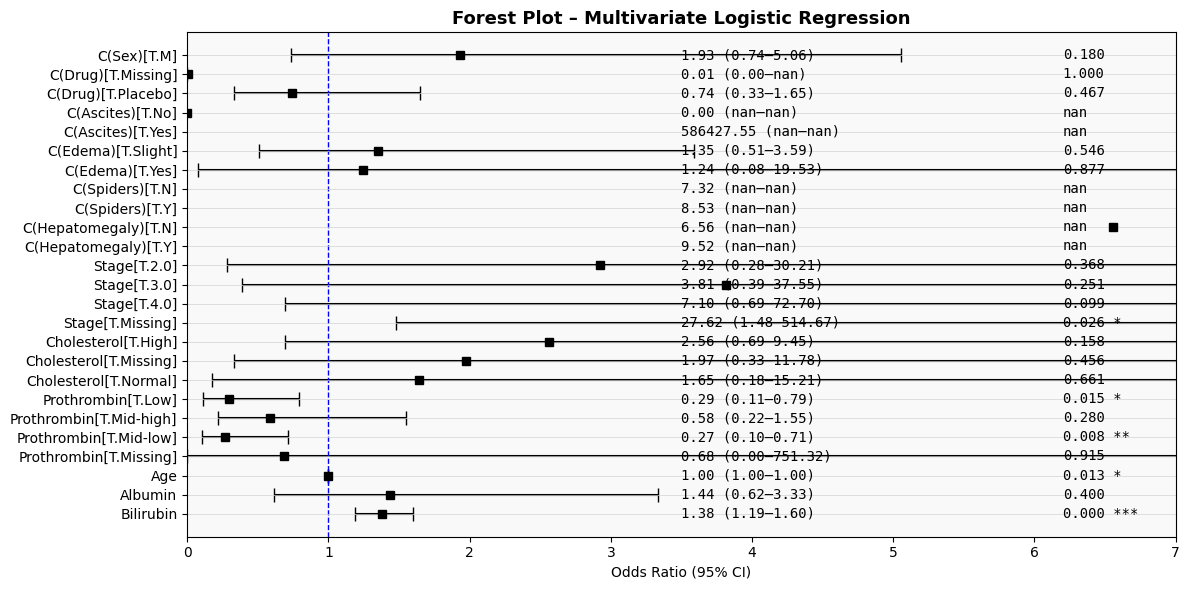

In [9]:
# ==============================================
# Section 2.5 – Forest Plot (Styled for Display)
# ==============================================

# Load the model results
df = pd.read_csv("multivariate_logistic_results.csv")

# Remove the Intercept row (not relevant for display)
df = df[df["Variable"] != "Intercept"]

# Create a column with OR (95% CI) text
df["OR_label"] = df.apply(lambda row: f"{row['OR']:.2f} ({row['CI_lower']:.2f}–{row['CI_upper']:.2f})", axis=1)

# Create a column for p-value with significance stars
def pval_stars(p):
    if p < 0.001:
        return f"{p:.3f} ***"
    elif p < 0.01:
        return f"{p:.3f} **"
    elif p < 0.05:
        return f"{p:.3f} *"
    else:
        return f"{p:.3f}"

df["p_label"] = df["P-value"].apply(pval_stars)

# Calculate error values for error bars
ci_low = df["OR"] - df["CI_lower"]
ci_high = df["CI_upper"] - df["OR"]

# Start plotting
fig, ax = plt.subplots(figsize=(12, 6))
y_pos = np.arange(len(df))

# Error bars and point markers
ax.errorbar(df["OR"], y_pos, xerr=[abs(ci_low), abs(ci_high)],
            fmt='s', color='black', capsize=5, markersize=6)

# Vertical line at OR = 1
ax.axvline(x=1, color='blue', linestyle='--', lw=1)

# Table-like horizontal lines
for i in range(len(df)):
    ax.axhline(y=i, color='lightgray', linestyle='-', linewidth=0.5)

# Set Y-axis labels
ax.set_yticks(y_pos)
ax.set_yticklabels(df["Variable"], fontsize=10)
ax.invert_yaxis()

# OR label and p-value label to the right
for i, (or_label, pval) in enumerate(zip(df["OR_label"], df["p_label"])):
    ax.text(3.5, i, or_label, va='center', ha='left', fontsize=10, family='monospace')
    ax.text(6.2, i, pval, va='center', ha='left', fontsize=10, family='monospace')

# Plot settings
ax.set_xlim(0, 7)
ax.set_xlabel("Odds Ratio (95% CI)")
ax.set_title("Forest Plot – Multivariate Logistic Regression", fontsize=13, fontweight='bold')
ax.set_facecolor('#f9f9f9')

plt.tight_layout()
plt.savefig("forestplot_fully_styled.png")
plt.show()


# PART 3

In [10]:
# ==============================================
# 3.1 –load data, handle missing values, and create survival variables
# =========================

# Load the cleaned and categorized dataset
df = pd.read_csv("cirrhosis_categorized_clean.csv")

# Create time and event variables
df['time_days'] = df['N_Days']
df['status_event'] = (df['Status'] == 'D').astype(int)


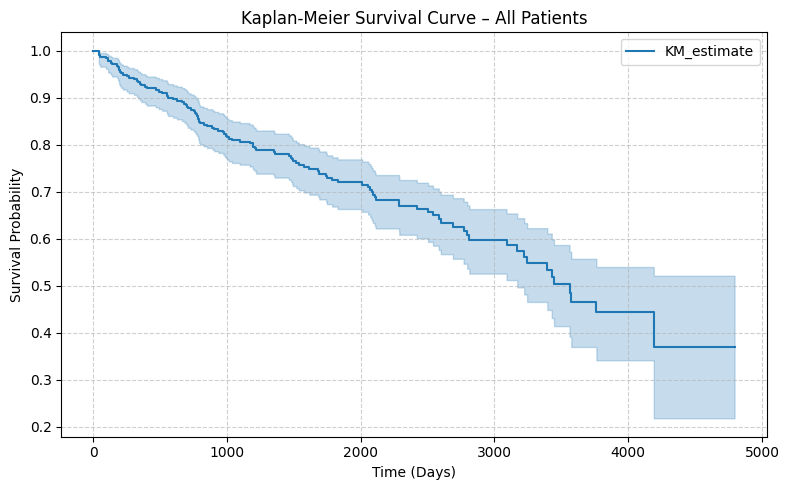

In [11]:
# ==============================================
# Part 3.2 – Kaplan-Meier Plot for the Entire Population
# ==============================================

kmf = KaplanMeierFitter()
kmf.fit(durations=df['time_days'], event_observed=df['status_event'])

plt.figure(figsize=(8, 5))
kmf.plot()
plt.title("Kaplan-Meier Survival Curve – All Patients")
plt.xlabel("Time (Days)")
plt.ylabel("Survival Probability")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("kmf_overall.png")
plt.show()

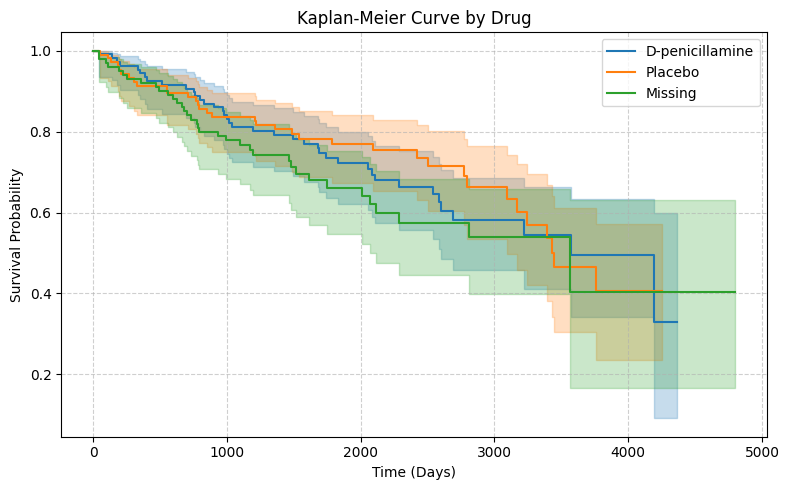

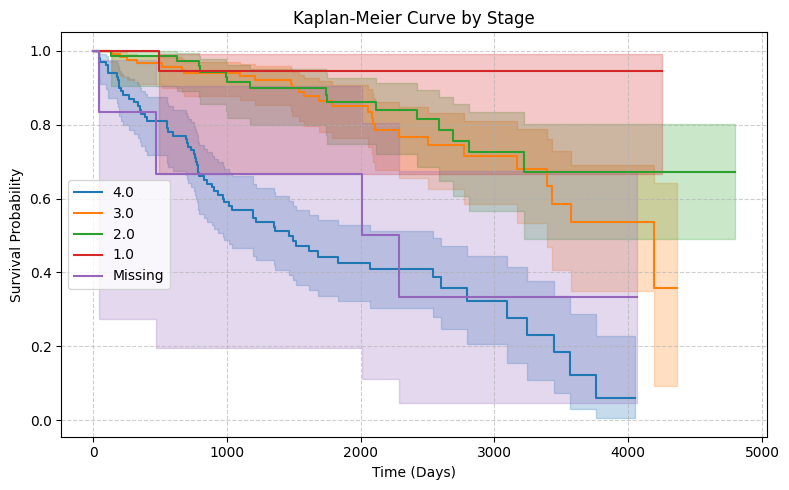

<ipython-input-12-3ca5cd73c72e>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


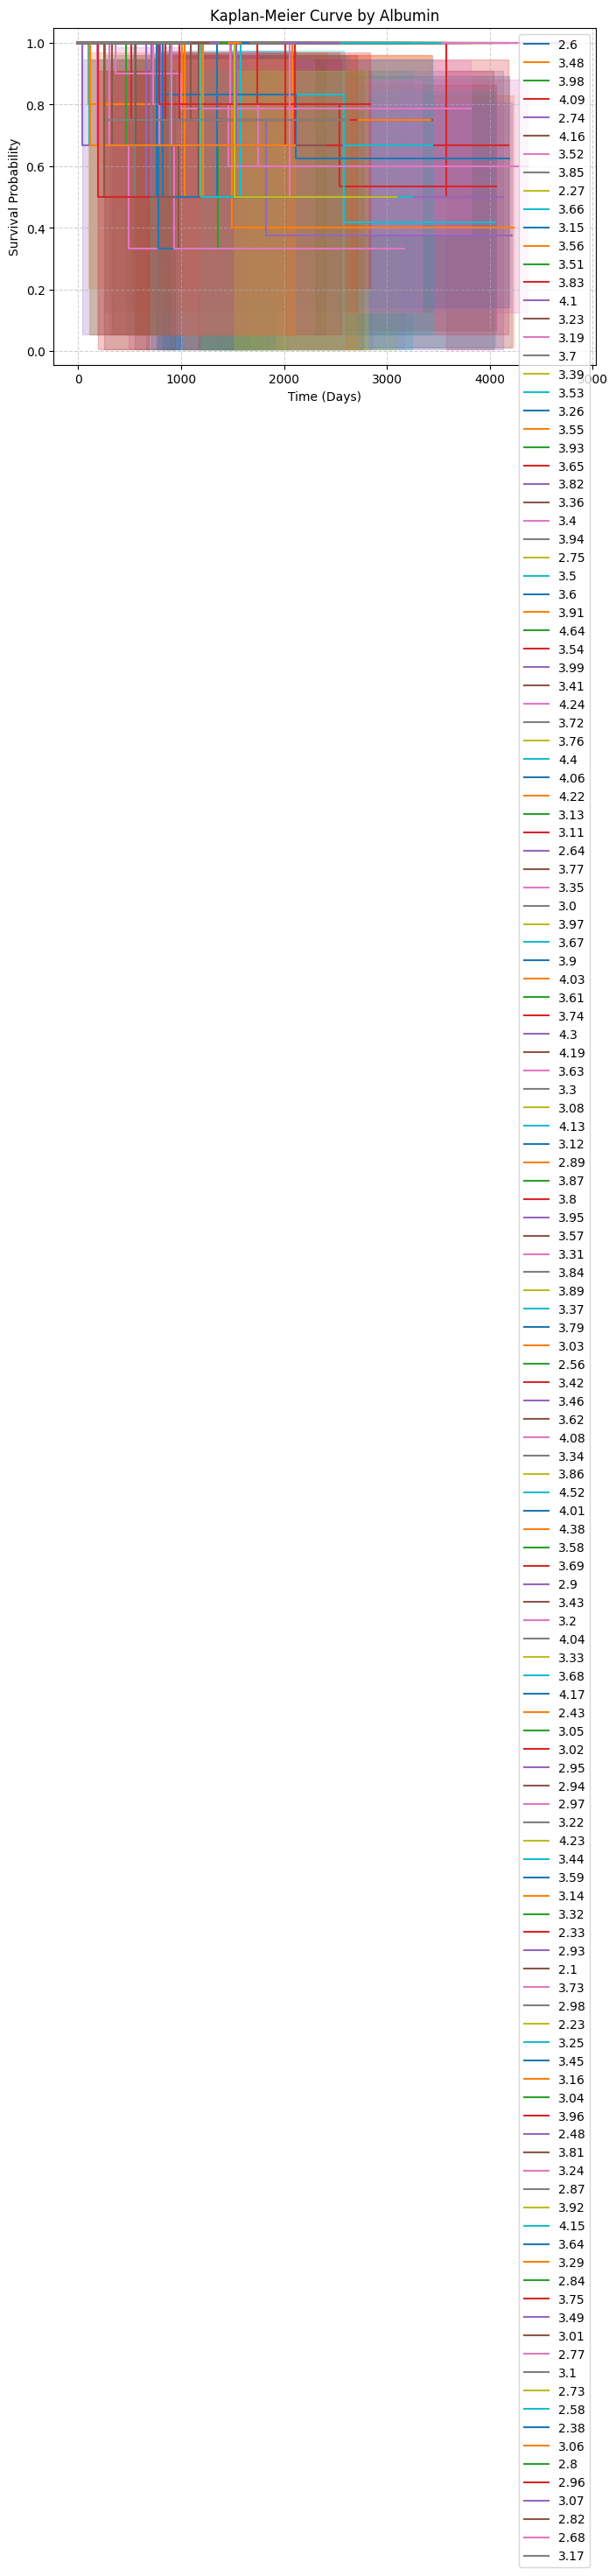

<ipython-input-12-3ca5cd73c72e>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


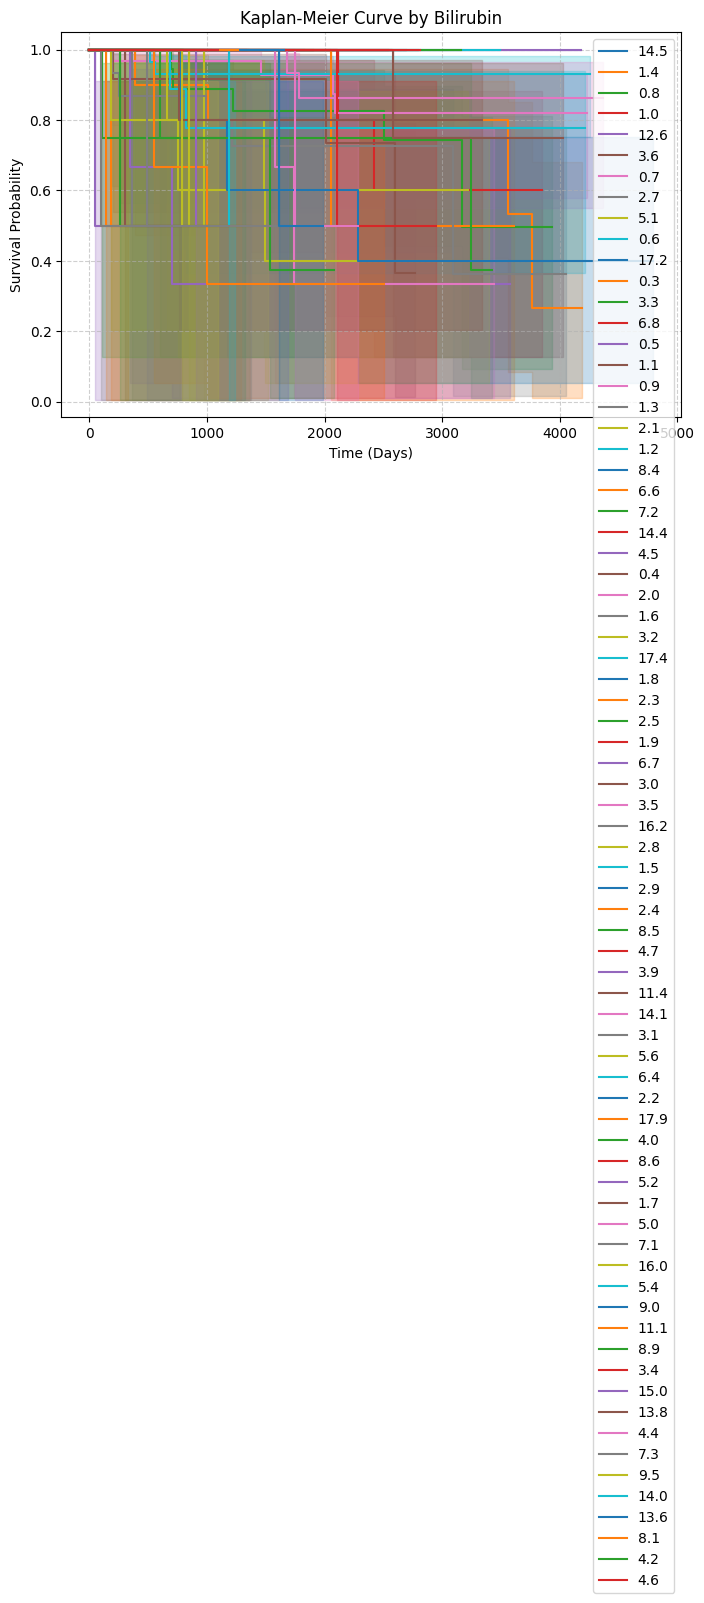

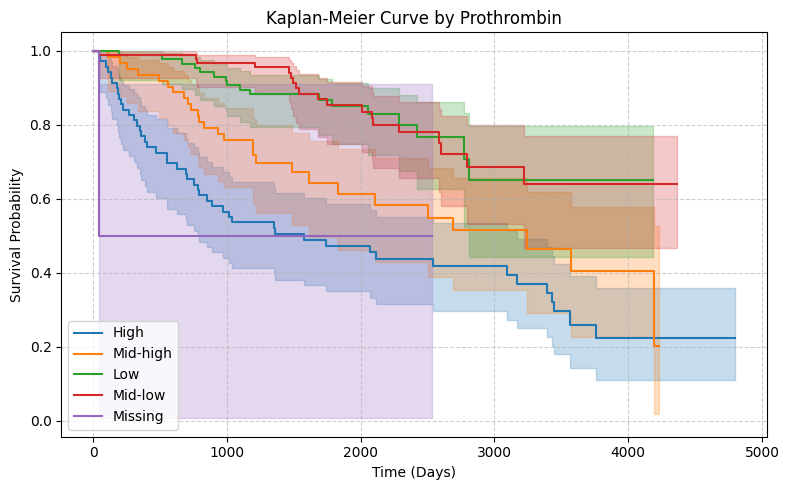

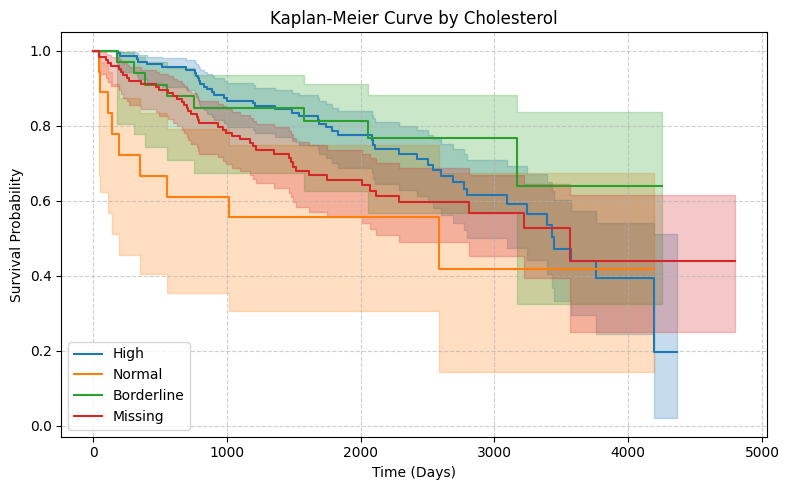

In [12]:
# ==============================================
# Part 3.3 – Kaplan-Meier by Categorical Variable
# ==============================================

# Define categorical variables to plot KM curves for
group_vars = ['Drug', 'Stage', 'Albumin', 'Bilirubin', 'Prothrombin', 'Cholesterol']

# Plot KM curve for each variable
for var in group_vars:
    plt.figure(figsize=(8, 5))
    kmf = KaplanMeierFitter()
    for group in df[var].dropna().unique():
        mask = df[var] == group
        kmf.fit(durations=df[mask]['time_days'], event_observed=df[mask]['status_event'], label=str(group))
        kmf.plot()

    plt.title(f"Kaplan-Meier Curve by {var}")
    plt.xlabel("Time (Days)")
    plt.ylabel("Survival Probability")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"kmf_by_{var.lower()}.png")
    plt.show()


In [13]:
# ==============================================
# Part 3.4 – Cox Regression: Univariate and Multivariate
# ==============================================

from lifelines import CoxPHFitter

# Select variables for Cox regression
cox_vars = ['Age', 'Sex', 'Drug', 'Ascites', 'Edema', 'Stage',
            'Albumin', 'Bilirubin', 'Prothrombin', 'Cholesterol']

# Prepare dataframe
cox_df = df[['time_days', 'status_event'] + cox_vars].copy()

# Convert categorical variables to numeric codes
for var in cox_vars:
    if df[var].dtype.name == 'category' or df[var].dtype == object:
        cox_df[var] = pd.Categorical(df[var]).codes

# Remove rows containing -1 (Missing values coded as -1)
cox_df = cox_df[~(cox_df == -1).any(axis=1)]

# Fit Cox model
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='time_days', event_col='status_event')

# View model summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 311 total observations, 201 right-censored observations>
             duration col = 'time_days'
                event col = 'status_event'
      baseline estimation = breslow
   number of observations = 311
number of events observed = 110
   partial log-likelihood = -491.80
         time fit was run = 2025-05-31 06:47:04 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Age          0.00      1.00      0.00            0.00            0.00                1.00                1.00
Sex          0.53      1.69      0.28           -0.02            1.07                0.98                2.93
Drug         0.03      1.03      0.12           -0.21            0.27                0.81                1.31
Ascites      0.33      1.39      0.20           -0.06            0.72                0.95                2.05
Edema        0.28      1.33      0.18           -0.07            0.64                0.93                1.89
Stage        0.51      1.66      0.13            0.25            0.77                1.28                2.15
Albumin     -0.55      0.58      0.26           -1.06           -0.05                0.35                0.95
Bilirubin    0.16      1.17      0.02            0.12            0.21                1.12                1.23
Prothrombin -0.09      0.91      0.09           -0.28            0.09                0.76                1.09
Cholesterol  0.33      1.39      0.15            0.04            0.63                1.04                1.87

             cmp to     z      p  -log2(p)
covariate                                 
Age            0.00  2.33   0.02      5.67
Sex            0.00  1.88   0.06      4.06
Drug           0.00  0.25   0.80      0.32
Ascites        0.00  1.68   0.09      3.42
Edema          0.00  1.56   0.12      3.09
Stage          0.00  3.84 <0.005     13.01
Albumin        0.00 -2.15   0.03      4.98
Bilirubin      0.00  7.20 <0.005     40.58
Prothrombin    0.00 -1.03   0.31      1.71
Cholesterol    0.00  2.20   0.03      5.17
---
Concordance = 0.83
Partial AIC = 1003.60
log-likelihood ratio test = 153.34 on 10 df
-log2(p) of ll-ratio test = 90.08

In [14]:
# ==============================================
# Part 3.5 – Hazard Ratios and p-value Table
# ==============================================

import numpy as np

# Extract model summary and format
summary_df = cph.summary.copy()
summary_df['HR'] = np.exp(cph.params_)
summary_df['95% CI'] = summary_df.apply(
    lambda row: f"{np.exp(row['coef lower 95%']):.3f}, {np.exp(row['coef upper 95%']):.3f}",
    axis=1
)
summary_df = summary_df[['HR', '95% CI', 'p']].round(3)

# Save to CSV
summary_df.to_csv("cox_regression_results.csv")

# Display
summary_df

,HR,95% CI,p
covariate,,,
Age,1.000,"1.000, 1.000",0.020
Sex,1.691,"0.978, 2.926",0.060
Drug,1.031,"0.810, 1.313",0.801
Ascites,1.391,"0.946, 2.045",0.093
Edema,1.327,"0.931, 1.891",0.118
Stage,1.660,"1.282, 2.149",0.000
Albumin,0.576,"0.348, 0.952",0.032
Bilirubin,1.175,"1.124, 1.228",0.000
Prothrombin,0.910,"0.760, 1.090",0.305


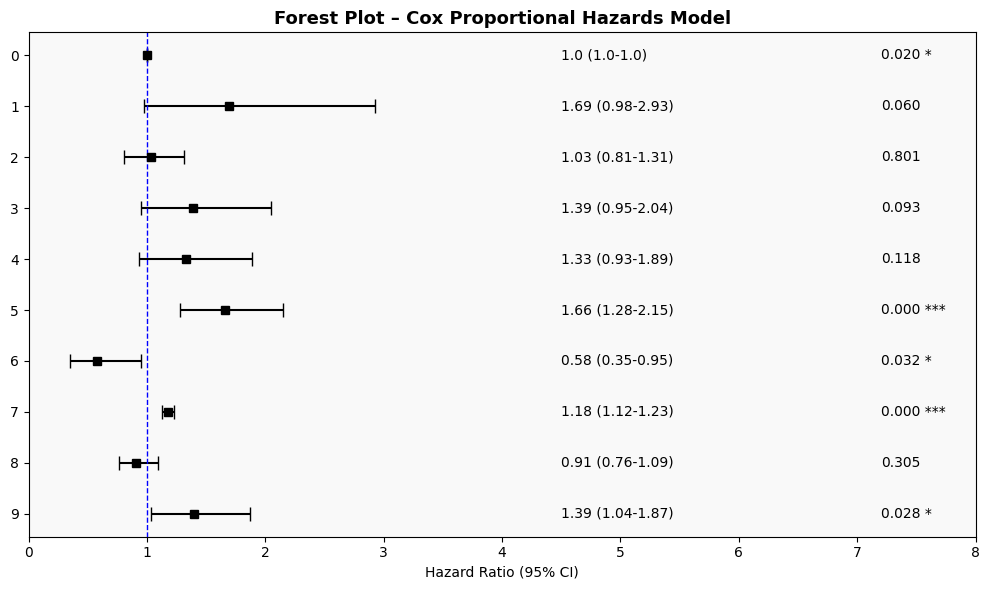

In [15]:
# ==============================================
# Section 3.6 – Forest Plot for Cox Regression
# ==============================================

# Load Cox regression results
summary_df = pd.read_csv("cox_regression_results.csv")

# Extract numerical values for plot
hr = summary_df['HR']
ci_bounds = summary_df['95% CI'].str.extract(r"(\d*\.?\d+), (\d*\.?\d+)").astype(float)
ci_lower = ci_bounds[0]
ci_upper = ci_bounds[1]
xerr = [np.abs(hr - ci_lower), np.abs(ci_upper - hr)]

# Positioning
y_pos = np.arange(len(hr))
ci_labels = hr.round(2).astype(str) + ' (' + ci_lower.round(2).astype(str) + '-' + ci_upper.round(2).astype(str) + ')'

# Format p-values with stars
def pval_stars(p):
    if p < 0.001:
        return f"{p:.3f} ***"
    elif p < 0.01:
        return f"{p:.3f} **"
    elif p < 0.05:
        return f"{p:.3f} *"
    else:
        return f"{p:.3f}"

p_labels = summary_df['p'].apply(pval_stars)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(hr, y_pos, xerr=xerr, fmt='s', color='black', capsize=5)

# Set labels and grid
ax.set_yticks(y_pos)
ax.set_yticklabels(summary_df.index)
ax.axvline(1, color='blue', linestyle='--', lw=1)

# Add text annotations
for i, (ci_text, p_text) in enumerate(zip(ci_labels, p_labels)):
    ax.text(4.5, i, ci_text, va='center', ha='left', fontsize=10)
    ax.text(7.2, i, p_text, va='center', ha='left', fontsize=10)

# Plot styling
ax.set_xlim(0, 8)
ax.invert_yaxis()
ax.set_xlabel("Hazard Ratio (95% CI)")
ax.set_title("Forest Plot – Cox Proportional Hazards Model", fontsize=13, fontweight='bold')
ax.set_facecolor('#f9f9f9')

plt.tight_layout()
plt.savefig("forest_plot_cox_styled.png", dpi=300)
plt.show()